In [1]:
import sys
sys.path.append("/home/bl9/gempy/")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

from gempy import Topology

import vtk

In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 50,50,50],
                         path_f = "/home/bl9/gempy//input_data/FabLessPoints_Foliations.csv",
                         path_i = "/home/bl9/gempy//input_data/FabLessPoints_Points.csv")
geo_data.n_faults = 1

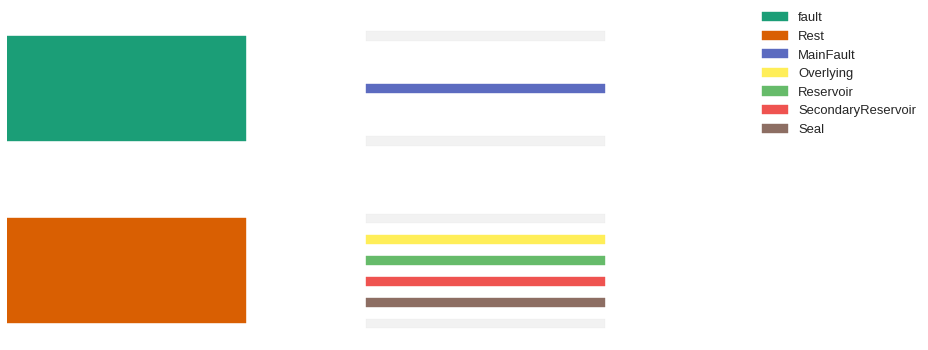

In [3]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Reservoir', 'Seal', 'SecondaryReservoir', 'Overlying')},
                       order_series = ["fault",
                                       "Rest",
                                       ], verbose=0)

In [4]:
geo_data.set_formation_number(['MainFault', 'Overlying', 'SecondaryReservoir', 'Seal', 
                               'Reservoir'])

In [5]:
#gp.data_to_pickle(geo_data, 'BasicFault') #saving data to pickle

In [6]:
#geo_data.interfaces.head()

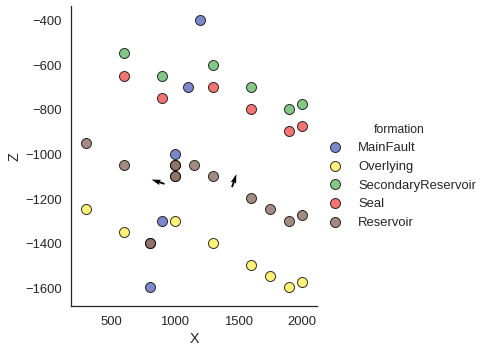

In [7]:
gp.plot_data(geo_data)

In [8]:
#gp.plot_data_3D(geo_data)

In [9]:
# INTERPOLATION
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3],
                                   compile_theano=True)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


In [10]:
# COMPUTATION OF THE MODEL
sol, pot = gp.compute_model(interp_data, get_potential_at_interfaces=True)
sol.shape

(1, 3, 125000)

In [11]:
# CREATING SURFACES FOR LAYERS
res_surf, res_surf_simp = gp.get_surfaces(potential_block=sol[0,1,:], interp_data = interp_data, n_formation = (interp_data.get_formation_number()['Reservoir']))
overlying_surf, overlying_surf_simp = gp.get_surfaces(potential_block=sol[0,1,:], interp_data = interp_data, n_formation = (interp_data.get_formation_number()['Overlying']))
sec_res_surf, sec_res_surf_simp = gp.get_surfaces(potential_block=sol[0,1,:], interp_data = interp_data, n_formation = (interp_data.get_formation_number()['SecondaryReservoir']))
seal_surf, seal_surf_simp = gp.get_surfaces(potential_block=sol[0,1,:], interp_data = interp_data, n_formation = (interp_data.get_formation_number()['Seal']))

In [12]:
#geo_data.get_formation_number().keys()

In [13]:
#geo_data.get_formations()

In [14]:
#geo_data.get_formation_number()

In [15]:
#gp.plot_surfaces_3D(geo_data, [sec_res_surf, seal_surf, res_surf, overlying_surf], 
#                    [sec_res_surf_simp, seal_surf_simp, res_surf_simp, overlying_surf_simp], 
#                    ["SecondaryReservoir", "Seal", 'Reservoir', "Overlying"], [1,2,3,4])

In [16]:
#gp.plot_surfaces_3D(geo_data, [res_surf], [res_surf_simp], ['Reservoir'], [3])

In [17]:
resolution = 50
model_size = 2000
scale_factor = (model_size/resolution) #original grid in [m]/grid resolution --> what if model not cubic?

In [18]:
# SPILL AND LEAK POINT FUNCTIONS

# Finding the spill point
def spill_point(res_surface):
    mini = argrelextrema(res_surface[:,2], np.less, order=10)
    minima = np.array(list(zip(np.take(res_surface[:,1], mini[0]), np.take(res_surface[:,0], mini[0]), np.take(res_surface[:,2], mini[0]))))
    fault_thresh = minima[:,1] > 700 #taking only relevant side by setting a threshold visually estimated, best: 20
    spill_min_line = minima[fault_thresh]
    spill_pos = np.array(np.argmax(spill_min_line[:,2]))
    spill_z = np.take(spill_min_line[:,2], spill_pos)
    spill_p = np.array([np.take(spill_min_line[:,1], spill_pos), np.take(spill_min_line[:,0],
                                spill_pos), np.take(spill_min_line[:,2], spill_pos)])
    
    # Horizontal plane defined by z-pos of spill
    if True:
        spill_bottom = np.ones_like(res_surface)
        spill_bottom[:,0] = res_surface[:,0]
        spill_bottom[:,1] = res_surface[:,1]
        spill_bottom[:,2] = spill_z    
    
    return spill_z, spill_p, spill_min_line, spill_bottom

# Finding the leak point ( critically inefficient method! takes 10s!)
def leak_point(res_surface):
    counter = 0
    # Creating empty lists and arrays to save values
    xvals = []
    yvals = []
    zvals = []
    leak_min = np.empty((0,3), dtype=int)
    #leak_min = np.empty([3,], dtype=int)
    
    for i in np.unique(res_surface[:,1]):
        
    #while counter < model_size:
        #print(counter)
        for e in res_surface:
            # Looking at a slice along y-axis for y = e[1] = counter, 
            # and appending x,y,z-values into lists
            # This is a way of RESORTING the array as needed
            #if int(e[1]) == counter:
            if e[1] == i:
                xvals.append(e[0])
                yvals.append(e[1])
                zvals.append(e[2])
            
        # Saving x,y,z-values as lists/arrays      
        zvals = np.array(zvals)
        yvals = np.array(yvals)
        xvals = np.array(xvals)

        # Looking fore minima positions in z-array
        min_pos = argrelextrema(zvals, np.less, order=10)
        
        # Saving x,y,z-positions of minima
        ypos = yvals[min_pos]
        xpos = xvals[min_pos]
        mins = zvals[min_pos]
        
        # Condition: Check if any minimum was found and if any data is given at y = counter
        # If no minimum found, restart loop at next iteration
        # This way, we can work with the data that coesn't cover every 1 step along the model
        # (such as the surface vertices)
        if len(mins) == 0:
            counter += 1
            #lists have to be emptied again
            xvals = []
            yvals = []
            zvals = []
            continue
        
        #np.append(leak_min, mins) -----> what did I use this for?
        
        # Create and array element to save coordinates of minima
        mins_pos = np.array(list(zip(xpos, ypos, mins)))
        # Save minima of slice into array of ALL minima
        leak_min = np.vstack((leak_min, mins_pos))

        # Empty lists for next iteration
        xvals = []
        yvals = []
        zvals = []
    
        counter += 1
        
    #leak_min = np.delete(leak_min, 0, 0) #what does this do???
    
    # Result of the loop above is one or SEVERAL lines of minima ("leak lines")
    # only want to look at the line bordering the fault surface
    # need for a general function/method to limit to only that line!
    # For now: Taking only relevant side by setting a threshold that is visually estimated
    near_fault_thresh = leak_min[:,0] < 1500 
    leak_line = leak_min[near_fault_thresh]
    
    # The highest point of the leak line is the leak point!
    leak_pos = np.array(np.argmax(leak_line[:,2]))
    leak_z = np.take(leak_line[:,2], leak_pos)

    # Full coordinates of the leak point as array element
    leak_p = np.array([np.take(leak_line[:,1], leak_pos), np.take(leak_line[:,0], leak_pos), np.take(leak_line[:,2], leak_pos)])
    
    # Creating a horizontal plane defined by the leak point z-position, in shape of res_surface
    leak_bottom = np.ones_like(res_surface)
    leak_bottom[:,0] = res_surface[:,0]
    leak_bottom[:,1] = res_surface[:,1]
    leak_bottom[:,2] = leak_z
   
    return leak_z, leak_p, leak_line, leak_bottom

In [19]:
# MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith,fault, bottom_z, formation_nr):
    mask = np.ones_like(lith)
    mask[~formation_nr] = False
    mask[fault.astype(bool)] = False
    bottom_z = bottom_z/scale_factor
    mask = mask.reshape(50,50,50)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(125000,)
    return mask

# Function that sets all voxels of lith_block which are equal (or closest to) to the spill_z
# horizontal as belonging to the overlying seal 
# (the voxels is located on the border of reservoir and seal):
def set_spill_to_seal(geo_data, lith, max_z):
    lith_spill = np.argmin(np.abs(geo_data.grid.grid[:, 2]+np.abs(max_z)))
    bol_lith_spill = geo_data.grid.grid[:, 2] == geo_data.grid.grid[:, 2][lith_spill]
    lith[bol_lith_spill] = 6
    return lith
        ### Hpw to check in here, if single spill voxel = reservoir (5)??? Need x and y pos?

# Masking that confines the volume to ONLY those reservoir traps (from res_mask)
# that are NOT connected to the borders of the model (open system)
# Traps defined as CLOSED systems
def topo_analysis(lith, fault):
    fig = plt.figure()
    traps = []
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    topo = Topology.Topology(lith_pad, fault_pad)
    topo.draw_section(25)
    topo_block = topo.labels
    # Finding sections which are possible traps in the reservoir (formation number = 7)
    topo_keys = [int(k) for k in topo.lith_to_labels_lot["7"].keys()]
    pad_keys = [int(p) for p in topo.lith_to_labels_lot["8"].keys()]
    bool_block = np.zeros_like(topo_block)
    # Check for each possible trap section, if it is connected to a border
    for tk in topo_keys:
        print('Checking Section:', tk)
        # Saving enclosed sections as traps
        if topo.check_adjacency(tk, pad_keys[0]) == False:
            print("TRAP FOUND, section:", tk)
            traps.append(tk)
    if traps == []:
        print('No trap found! =(')
    else:
        for i in traps:
            # Creating a mask from the trap sections in the label block
            top_bool = topo_block == i
            bool_block[top_bool] = True
    # Removing padding
    trap_mask = bool_block[1:-1,1:-1,1:-1]
    plt.imshow(trap_mask[:,25,:].T, origin="lower")
    plt.show()
    return trap_mask

In [20]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps

def max_trap_vol(lith, fault, res_surface):
    # calculate spill point
    spill_z, spill_p, spill_min_line, spill_bottom = spill_point(res_surface)
    # calculate leak point
    leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
    
    # Dheck for "down-to" z-horizon, maximum depth of reservoir
    max_z = np.max([spill_z, leak_z])
    
    if max_z == spill_z:
        print("Down to spill.")
        bottom_surface = spill_bottom
    else:
        print("Down to leak.")
        bottom_surface = leak_bottom
    
    #print('Max_Z:', max_z)
    
    res_nr = lith == interp_data.get_formation_number()['Reservoir']
    pre_trap_mask = res_mask(lith, fault, max_z, res_nr)
          
    # volume cells for counting
    vol_cells = 0      
    
    pre_trap_mask_bool = (pre_trap_mask == True)
    lith[pre_trap_mask_bool] = 7                           # setting reservoir above bottom on footwall side 
                                                        # (incl. outside trap) to formation value = 7  
    if max_z == spill_z:
        lith = set_spill_to_seal(geo_data, lith, max_z)
    
    #test = lith.reshape(125000)                       
    #for i in range(len(test)):                         #to test pre-trap-masking volume
    #    if test[i] == 7:
    #        vol_cells +=1
    #res_vol = ((scale_factor)**3) * vol_cells 
    #print("VOLUME INCLUDING OUTSIDE TRAP:" ,res_vol)
    
    final_trap_mask = topo_analysis(lith, fault)
    lith[final_trap_mask] = 9                         # setting final trap to formation value = 9
    vol_cells = np.count_nonzero(final_trap_mask)
    
    #calulate volume from cells
    trap_vol = ((scale_factor)**3) * vol_cells 
    
    #PLOTTING OF SPILL, LEAK AND BOTTOM POSSIBLE HERE:
    #plot_spill(res_surface, spill_min_line, spill_p)
    #plot_leak(res_surface, leak_line, leak_p)
    #plot_trap(res_surface, bottom_surface, spill_p, leak_p)
    #PRINTING OF SPILL, LEAK:
    #print('Spill_Z:', spill_z)
    #print('Leak_Z:', leak_z)
    
    #return the maximum reservoir volume
    return trap_vol, lith, bottom_surface, final_trap_mask

In [21]:
# PLOTTING FUNCTIONS: Spill and leak point visualization

def plot_spill(res_surface, spill_min_line, spill_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-spill_min_line[:,0], -spill_min_line[:,1], spill_min_line[:,2], c='r', s = 50)
    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 200)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

def plot_leak(res_surface, leak_line, leak_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-leak_line[:,1], -leak_line[:,0], leak_line[:,2], c='r', s = 50)
    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 200)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()
    
def plot_trap(res_surface, bottom_surface, spill_p, leak_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(-bottom_surface[:,1], -bottom_surface[:,0], bottom_surface[:,2], c="r", alpha = 0.05)
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 1000)
    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 1000)

    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()
    

In [22]:
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z']
base_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Overlying']['Z']

res_len = len(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z'])

In [23]:
# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP

z_sec_res_top = pymc.Normal('z_unc_sec_res', 0, 1./0.0001)
z_seal_top = pymc.Normal('z_unc_seal', 0, 1./0.0003)
z_res_top = pymc.Normal('z_unc_res', 0, 1./0.0005)
z_over_top = pymc.Normal('z_unc_over', 0, 1./0.0008) 

In [24]:
@pymc.deterministic
def gempy_model(value=0, z_res_top = z_res_top):

    new_z = res_z + z_res_top
    print('Z-Variation:', z_res_top)
    #print('new', new_z)
    #print(res_z)
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'] = new_z
    
    sol, pot = gp.compute_model(interp_data, get_potential_at_interfaces=True)
    lith_block = sol[0, 0,:]
    fault_block = sol[0, 2,:]    
    res_surf, res_surf_simp = gp.get_surfaces(potential_block=sol[0, 1,:], 
                                          interp_data = interp_data, n_formation = (interp_data.get_formation_number()['Reservoir']),)

    max_vol, sol[0, 0,:], bottom, trap = max_trap_vol(lith_block, fault_block, res_surf)
    
    print("Maximum reservoir volume: %s m³" % max_vol)
    gp.plot_section(geo_data, sol[0, 0,:], 25, plot_data =1)
    
    #gp.plot_section(geo_data, sol[0, 0,:], 23
    #                , plot_data=1, direction='x')
  
    #gp.plot_surfaces_3D(geo_data, [res_surf], 
    #                [res_surf_simp], 
    #                ['Reservoir'], [3])
    return sol

Z-Variation: -0.010616680097007787


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


ValueError: attempt to get argmax of an empty sequence

In [ ]:
@pymc.deterministic
def model_unc_all(value=0, z_sec_res_top = z_sec_res_top, 
                  z_res_top = z_res_top, z_seal_top = z_seal_top, z_over_top = z_over_top):
    
    new_z_sec_res = sec_res_z + z_sec_res_top
    new_z_seal = seal_z + z_seal_top
    new_z_res = res_z + z_res_top
    new_z_over = over_z + z_over_top
    
    print('Z-Variations:', z_sec_res_top, z_seal_top, z_res_top, z_bover_top)
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'] = new_z_sec_res
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Seal'] = new_z_seal
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'] = new_z_res
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Overlying'] = new_z_base
   
    sol, pot = gp.compute_model(interp_data, get_potential_at_interfaces=True)
    lith_block = sol[0, 0,:]
    fault_block = sol[0, 2,:]
    res_surf, res_surf_simp = gp.get_surfaces(potential_block=sol[0, 1,:], 
                                          interp_data = interp_data, n_formation = (interp_data.get_formation_number()['Reservoir']),)
       
    max_vol, sol[0, 0,:], bottom, trap = max_trap_vol(lith_block, fault_block, res_surf)
    
    print("Maximum reservoir volume: %s m³" % max_vol)
    gp.plot_section(geo_data, sol[0, 0,:], 25, plot_data =1)
    
    #gp.plot_section(geo_data, sol[0, 0,:], 23
    #                , plot_data=1, direction='x')
  
    #gp.plot_surfaces_3D(geo_data, [res_surf], 
    #                [res_surf_simp], 
    #                ['Reservoir'], [3])
    return sol